The cells in this notebook are used to build my facial detection model using pytorch and the Kaggle Facial Keypoints data. The evaluation metric is RMSE and the model artifacts will be stored in the paths model1.pt and model2.pt

In [1]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Loading train and test data
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

train_path = '/content/drive/My Drive/Udacity-Intro to Pytorch/\
Convolutional Neural Networks/project-dog-classification/facial_keypoints_detection/data/training.csv'
test_path = '/content/drive/My Drive/Udacity-Intro to Pytorch/\
Convolutional Neural Networks/project-dog-classification/facial_keypoints_detection/data/test.csv'
sub_path = '/content/drive/My Drive/Udacity-Intro to Pytorch/\
Convolutional Neural Networks/project-dog-classification/facial_keypoints_detection/data/SampleSubmission.csv'


train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
SampleSubmission = pd.read_csv(sub_path)

In [3]:
from IPython.display import display

print('Train.shape: {}'.format(train.shape))
# The 'Image' column is the feature and it contains pixel vaules separated by space.
display(train.drop(['Image'], axis=1).head())
print()
print('Test.shape: {}'.format(test.shape))
display(test.head())
print()
print()
print('SampleSubmission.shape: {}'.format(SampleSubmission.shape))
display(SampleSubmission.head())

Train.shape: (7049, 31)


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166



Test.shape: (1783, 2)


,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...




SampleSubmission.shape: (27124, 2)


,RowId,Location
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [4]:
# Inspecting the feature
display(train['Image'].head())

0    238 236 237 238 240 240 239 241 241 243 240 23...
1    219 215 204 196 204 211 212 200 180 168 178 19...
2    144 142 159 180 188 188 184 180 167 132 84 59 ...
3    193 192 193 194 194 194 193 192 168 111 50 12 ...
4    147 148 160 196 215 214 216 217 219 220 206 18...
Name: Image, dtype: object

In [5]:
# Checking for missing values in the data
print(train.isnull().any().sum())
print(test.isnull().any().sum())

28
0


In [6]:
# filling null 
train = train.fillna(method='ffill')
print(train.isnull().any().sum())

0


In [7]:
from tqdm import tqdm_notebook

images = [train['Image'][i].split(' ') for i in tqdm_notebook(range(train.shape[0]))]
images = np.array(images, dtype='float')
images = images.reshape(-1, 96, 96, 1)

face_keys = train[train.columns[:-1]].values
# scale target coordinates to [-1, 1]
face_keys = (face_keys - 48) / 48  
face_keys = face_keys.astype(np.float32)

def visualize(img_list, num_imgs=10, p_=5, plot_points=False, from_pred=False, keys=None):
  # visualizing some of the images
  fig = plt.figure(figsize=(12, 12))
  fig.subplots_adjust(
      left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
  
  
  if not plot_points:
    for i, j in zip(img_list[:num_imgs], range(num_imgs)):
      if not from_pred:
        img = i.reshape(96, 96)
      else:
        img = i
      ax = fig.add_subplot(p_, p_, j + 1, xticks=[], yticks=[])
      ax.imshow(img, cmap='gray')
  else:
    for i, j, y in zip(img_list[:num_imgs], range(num_imgs), keys[:num_imgs]):
      ax = fig.add_subplot(p_, p_, j + 1, xticks=[], yticks=[])
      if not from_pred:
        img = i.reshape(96, 96)
        ax.imshow(img, cmap='gray')
        ax.scatter(y[::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10, c='red')
      else:
        img = i
        ax.imshow(img, cmap='gray')
        ax.scatter(y[::2], y[1::2], marker='x', s=10, c='red')

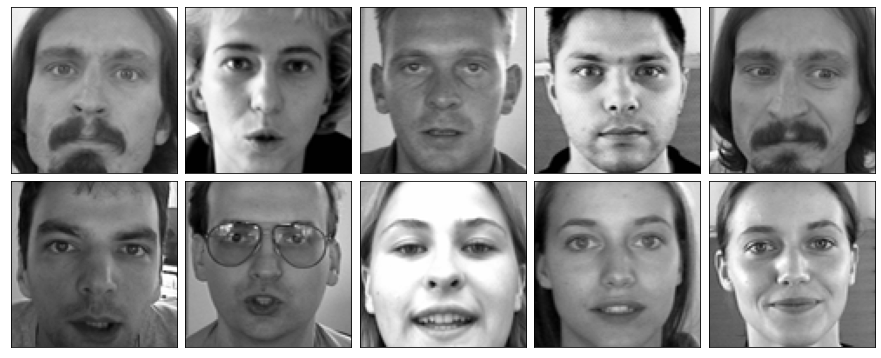

In [8]:
# Visualizing images

visualize(images)

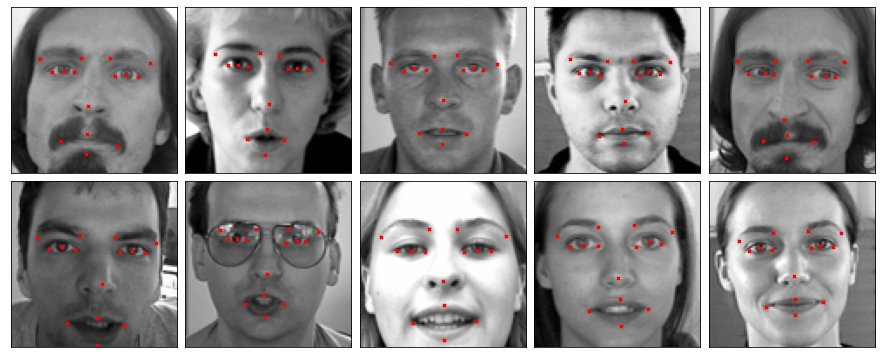

In [9]:
# Visualizing images with keypoints

visualize(images, plot_points=True, keys=face_keys)



## Build Model
Since our training data and labels are ready, let us define and train our models. First, we transform the data (possibly augmenting the images to improve
performance), then we define the model architecture, train and evaluate it.

In [10]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import Variable
from sklearn.utils import shuffle
torch.manual_seed(42)


class FaceKeyPointsDataset(Dataset):

  def __init__(self, X, y, transforms=None):
        
    self.transform = transforms    
    self.X = X
    self.y = y
        
  def __getitem__(self, index):
    image = self.X[index]
    keypoints = self.y[index]        
        
    if self.transform:
      image = self.transform(image)
            
    return image, keypoints

  def __len__(self):
    return len(self.X)


class ToTensor(object):

  def __call__(self, image):
    # imagem numpy: C x H x W
    # imagem torch: C X H X W
                    
    image = image.transpose((0, 1, 2))
    return torch.from_numpy(image)

class CloneArray(object):
    
  def __call__(self, image):
    image = image.repeat(3, axis=0)
    return image


mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
                                 CloneArray(),
                                 ToTensor(),
                                 transforms.Normalize(mean, std)]),

    'valid': transforms.Compose([
                                 CloneArray(),
                                 ToTensor(),
                                 transforms.Normalize(mean, std)])
}


def create_dataLoader(dsets, batch_size, sampler={'train': None, 'valid': None,'test': None},
                      pin_memory=False):
  
  dset_loaders = {} 
  for key in dsets.keys():
    if sampler[key] != None:
      dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, sampler=sampler[key], pin_memory=pin_memory)
    else:          
      dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, pin_memory=pin_memory, shuffle=False)

  return dset_loaders


def get_data(data, is_test = False):

  data['Image'] = data['Image'].apply(lambda img:  np.fromstring(img, sep = ' '))
  X = np.vstack(data['Image'].values)
  X = X / 255.   # scale pixel values to [0, 1]
  X = X.astype(np.float32)
  X = X.reshape(-1, 1, 96, 96) # return each images as 1 x 96 x 96

  if not is_test:
    y = data[data.columns[:-1]].values
    y = (y - 48) / 48 
    y = y.astype(np.float32)
  else:
    y = np.zeros((len(X)))

  return X, y

In [11]:
# Preparing the data

X_train, y_train = get_data(train)
X_test, y_test = get_data(test, is_test=True)

In [12]:
dsets = {
    'train': FaceKeyPointsDataset(X_train, y_train, transforms=data_transforms['train']),
    'valid': FaceKeyPointsDataset(X_train, y_train, transforms=data_transforms['valid']),
    'test':  FaceKeyPointsDataset(X_test, y_test, transforms=data_transforms['valid']),
}

In [13]:
from torch.utils.data.sampler import SubsetRandomSampler
batch_size = 30
random_seed = 42
valid_size = 0.2
shuffle = True

num_train = len(dsets['train'])
print(num_train)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

sampler = {'train': train_sampler,
          'valid': valid_sampler,
          'test': None}

dset_loaders = create_dataLoader(dsets, batch_size, sampler)

7049


In [14]:
# Creating a dictionary to hold all the data
data_list = [dset_loaders['train'], dset_loaders['valid'], dset_loaders['test']]

In [15]:
image, keypoints = next(iter(data_list[0]))
image.size(), keypoints.size()

(torch.Size([30, 3, 96, 96]), torch.Size([30, 30]))

In [16]:
# Defining Model Architecture
# Here, we are going to use CNNs
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):

  def __init__( self ):
    super( Net, self ).__init__()

    # Defining layers of the CNN
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv5 = nn.Conv2d(128, 256, 3, padding=1)

    # max pooling layer
    self.pool = nn.MaxPool2d(2,2)

    # Linear layer
    self.fc1 = nn.Linear(256 * 3 * 3, 4096)
    self.fc2 = nn.Linear(4096, 2048)
    #self.fc3 = nn.Linear(1024, 500)
    self.predict = nn.Linear(2048, 30)

    
    # Batch Norm conv
    self.conv1_bn = nn.BatchNorm2d(16)
    self.conv2_bn = nn.BatchNorm2d(32)
    self.conv3_bn = nn.BatchNorm2d(64)
    self.conv4_bn = nn.BatchNorm2d(128)
    self.conv5_bn = nn.BatchNorm2d(256)
        
    # Batch Norm linear
    self.fc1_bn = nn.BatchNorm1d(4096)
    self.fc2_bn = nn.BatchNorm1d(2048)
    #self.fc3_bn = nn.BatchNorm1d(500)

    # Droupout Layer
    self.dropout = nn.Dropout(0.5)

  def forward( self, x ):
    ## Define forward behavior
    x = self.pool(F.leaky_relu(self.conv1_bn(self.conv1(x))) )
    x = self.pool(F.leaky_relu(self.conv2_bn(self.conv2(x))))
    x = self.pool(F.leaky_relu(self.conv3_bn(self.conv3(x))))
    x = self.pool(F.leaky_relu(self.conv4_bn(self.conv4(x))))
    x = self.pool(F.leaky_relu(self.conv5_bn(self.conv5(x))))
        
    # flatten image input
    x = x.view(-1, 256 * 3 * 3 )
        
    # add 1st hidden layer, with relu activation function
    x = F.leaky_relu( self.fc1_bn(self.fc1(x)) )
    x = self.dropout(x)
    # add 2nd hidden layer, with relu activation function
    x = F.leaky_relu( self.fc2_bn(self.fc2(x)) )
    x = self.dropout(x)
    # add 3rd hidden layer
    x = self.predict(x)
    return x

# Instantiate the model
model = Net()
use_cuda = torch.cuda.is_available()
if use_cuda:
  model.cuda()
summary(model, (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 96, 96]             448
       BatchNorm2d-2           [-1, 16, 96, 96]              32
         MaxPool2d-3           [-1, 16, 48, 48]               0
            Conv2d-4           [-1, 32, 48, 48]           4,640
       BatchNorm2d-5           [-1, 32, 48, 48]              64
         MaxPool2d-6           [-1, 32, 24, 24]               0
            Conv2d-7           [-1, 64, 24, 24]          18,496
       BatchNorm2d-8           [-1, 64, 24, 24]             128
         MaxPool2d-9           [-1, 64, 12, 12]               0
           Conv2d-10          [-1, 128, 12, 12]          73,856
      BatchNorm2d-11          [-1, 128, 12, 12]             256
        MaxPool2d-12            [-1, 128, 6, 6]               0
           Conv2d-13            [-1, 256, 6, 6]         295,168
      BatchNorm2d-14            [-1, 25

In [17]:
len(data_list[0]), len(data_list[1]), len(data_list[2])

(188, 47, 60)

In [18]:
# writing the train function
from statistics import mean
def train_model(n_epochs, data_list, batch_size, model, optimizer, criterion, use_cuda, save_path):
  # Initialize trackers for loss
  valid_loss_min = np.Inf
  rmse_loss = {'train':[], 'valid':[]}

  for epoch in range(1, n_epochs+1):
    # initialize variables to monitor training and validation loss
    #train_loss = valid_loss = 0.0
    train_loss =[]
    valid_loss = []

    #####################
    #### train model ####
    #####################
    model.train()
    
    
    for batch_idx, (img, key) in enumerate(data_list[0]):
      # move to cuda
      if use_cuda:
        img, key = Variable(img.float().cuda()), Variable(key.float().cuda())

      # clear accumulated gradients
      optimizer.zero_grad()
      # forward pass
      prediction = model(img.requires_grad_())
      # calculate the batch loss
      loss = criterion(prediction, key)
      # backward pass
      loss.backward()
      # parameter update
      optimizer.step()
      # calculate loss
      #train_loss = loss.item()*img.size(0) #train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
      train_loss.append(loss.item())
      
    ######################
    ### validate model ###
    #######################
    model.eval()

    for batch_idx, (img, key) in enumerate(data_list[1]):
      # move to cuda
      if use_cuda:
        img, key = Variable(img.float().cuda()), Variable(key.float().cuda())

      # clear accumulated gradients
      optimizer.zero_grad()
      # forward pass
      prediction = model(img.requires_grad_())
      # calculate the batch loss
      loss = criterion(prediction, key)
      # backward pass
      loss.backward()
      # parameter update
      optimizer.step()
      # calculate loss
      #valid_loss += loss.item()*img.size(0) #valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
      valid_loss.append(loss.item())
      
    # tracking total losses
    train_loss = mean(train_loss)
    valid_loss = mean(valid_loss)
    rmse_loss['train'].append(train_loss)
    rmse_loss['valid'].append(valid_loss)
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, 
          train_loss,
          valid_loss
          ))
        
    ## save the model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), save_path)
        valid_loss_min = valid_loss
             
  # return trained model and losses
  return model, rmse_loss

In [19]:
# Our loss criterion will be RMSE loss, but pytorch only has function for MSE loss
# so we define a fuction to account for the 'root' in the MSE loss

class RMSELoss(nn.Module):
  def __init__(self, eps=1e-6):
    super().__init__()
    self.mse = nn.MSELoss()
    self.eps = eps
        
  def forward(self,yhat,y):
    loss = torch.sqrt(self.mse(yhat,y) + self.eps)
    return loss

In [20]:
# Defining the Optimizer and criterion
import torch.optim as optim

optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
criterion = RMSELoss()
n_epochs = 500

In [21]:
# Training the model
model_path = '/content/drive/My Drive/Udacity-Intro to Pytorch/\
Convolutional Neural Networks/project-dog-classification/facial_keypoints_detection/'

In [22]:
%time

model_trained, rmse = train_model(n_epochs, data_list, batch_size, model, optimizer, criterion, use_cuda, model_path+'model.pt')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
Epoch: 1 	Training Loss: 0.387422 	Validation Loss: 0.182877
Validation loss decreased (inf --> 0.182877).  Saving model ...
Epoch: 2 	Training Loss: 0.232062 	Validation Loss: 0.134259
Validation loss decreased (0.182877 --> 0.134259).  Saving model ...
Epoch: 3 	Training Loss: 0.180745 	Validation Loss: 0.112442
Validation loss decreased (0.134259 --> 0.112442).  Saving model ...
Epoch: 4 	Training Loss: 0.157848 	Validation Loss: 0.096919
Validation loss decreased (0.112442 --> 0.096919).  Saving model ...
Epoch: 5 	Training Loss: 0.144292 	Validation Loss: 0.092248
Validation loss decreased (0.096919 --> 0.092248).  Saving model ...
Epoch: 6 	Training Loss: 0.128041 	Validation Loss: 0.103170
Epoch: 7 	Training Loss: 0.117027 	Validation Loss: 0.090455
Validation loss decreased (0.092248 --> 0.090455).  Saving model ...
Epoch: 8 	Training Loss: 0.109469 	Validation Loss: 0.083406
Validation loss decreased (0.090455 -->

In [23]:
# Loading trained model
model_trained.load_state_dict(torch.load(model_path+'model.pt'))

<All keys matched successfully>

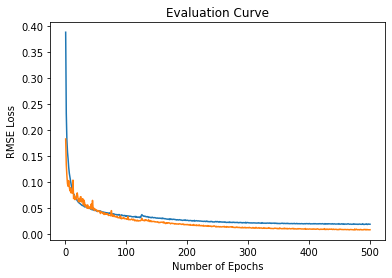

In [24]:
# visualizing the evaluation curve

x_plot = np.arange(1, 501, 1)
plt.plot(x_plot, rmse['train'], label='train')
plt.plot(x_plot, rmse['valid'], label='valid')
plt.ylabel('RMSE Loss')
plt.xlabel('Number of Epochs')
plt.title('Evaluation Curve');

In [25]:
## Writting the Predict function

def predict(img):

  if use_cuda:
    model = model_trained.cuda()
    img = Variable(img.float().cuda())

  model.eval()

  prediction = model(img)
  prediction = prediction.detach().cpu().numpy()

  if len(prediction) > 0:
    return prediction

In [26]:
# Getting predictions

predictions = []
for ii, (image, label) in tqdm_notebook(enumerate(data_list[2])):
  batch_array = predict(image)
  for s_img in batch_array:
    predictions.append(s_img)

print('Facial Keypoints for {} of {} images in test dataset predicited!'\
      .format(len(predictions), test.shape[0]))


Facial Keypoints for 1783 of 1783 images in test dataset predicited!


In [27]:
# Visualizing facial keypoints for original and predicted images in train data

img_list = []
img_keys = []
for ii, (image, label) in tqdm_notebook(enumerate(data_list[0])):
  img_batch = image
  key_batch = label
  for s_img, s_key in zip(img_batch, key_batch):
    img_keys.append(s_key.detach().cpu().numpy())
    img_list.append(s_img.detach().cpu().numpy())


pred_keys = []
for ii, (image, label) in tqdm_notebook(enumerate(data_list[0])):
  batch_array = predict(image)
  for s_img in batch_array:
    pred_keys.append(s_img)

In [28]:
len(img_list), len(pred_keys), len(img_keys)

(5640, 5640, 5640)

In [ ]:
def denormalize(image, mean=mean, std=std):
  inp = image.transpose((1, 2, 0))
  img = std * inp + mean
  return img

In [29]:
img_list = [np.clip(denormalize(img_list[i]), 0, 1.0) for i in range(len(img_list))]
img_keys = [img_keys[ii] * 48+48 for ii in range(len(img_keys))]
pred_keys = [pred_keys[i] * 48+48 for i in range(len(pred_keys))]

Plotting Original Facial Keypoints...........


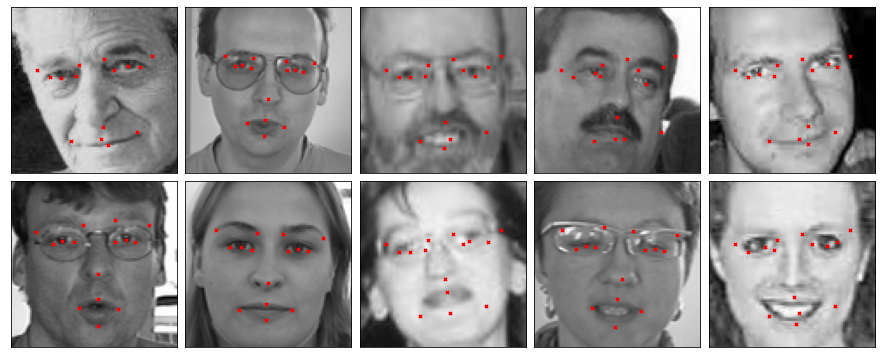

In [30]:
print("Plotting Original Facial Keypoints...........")
visualize(img_list, plot_points=True, from_pred=True, keys=img_keys)

Plotting Predicted Facial Keypoints...........


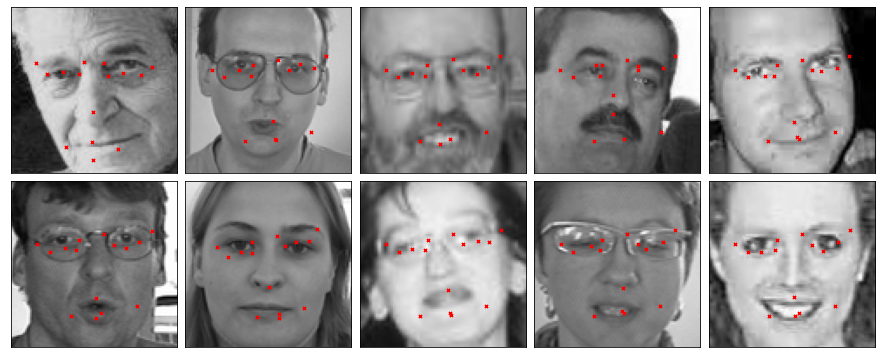

In [31]:
print("Plotting Predicted Facial Keypoints...........")
visualize(img_list, plot_points=True, from_pred=True, keys=pred_keys)

In [32]:
### Generating Submissions
id_path = '/content/drive/My Drive/Udacity-Intro to Pytorch/\
Convolutional Neural Networks/project-dog-classification/facial_keypoints_detection/data/IdLookupTable.csv'

id_lookup_frame = pd.read_csv(id_path)
val_reqrd = id_lookup_frame[["ImageId", "FeatureName"]]
val_reqrd.head()

,ImageId,FeatureName
0,1,left_eye_center_x
1,1,left_eye_center_y
2,1,right_eye_center_x
3,1,right_eye_center_y
4,1,left_eye_inner_corner_x


In [33]:
y_test = [predictions[i] * 48+48 for i in range(len(predictions))]
columns = train.columns[:-1]

In [36]:

def generate_output_submission(y_test, columns, filename = model_path+"result.csv"):
    y_res = []
    j = 0
    k = 0
    m = 0
    for i in range(1, len(y_test)+1):
        img = np.array(val_reqrd[val_reqrd["ImageId"]==i])
        if img.shape[0] == 30:
            y_res += list(y_test[i-1])
            j += 30
        else:
            slice_img = y_test[i-1]
            y_res += [slice_img[j] for j in range(30) if columns[j] in img[:, 1]]
            k += len([slice_img[j] for j in range(30) if columns[j] in img[:, 1]])
    y_res = np.array(y_res)

    
    result_dict = {
    "RowId": range(1,y_res.shape[0]+1),
    "Location": y_res
    }
    result_df = pd.DataFrame(result_dict, )
    result_df.to_csv(filename, index=False, columns=["RowId", "Location"])
    print('Done!')

In [37]:
generate_output_submission(y_test, columns)

Done!
